# _Text Normalization and Tokenization_

Machine learning algorithms technically don't work with text data, however, there is a workaround for this. By pre-processing the text, and then converting it into a numerical format (i.e. vectors of numbers), it is then in an appropriate format that can be fed into ML algorithms. But what does text pre-processing entail exactly?  

This is where things get interesting. From a high-level, preprocessing removes as much noise as possible from the text data, that way an algorithm can more readily find any potential patterns. But determining what is noise and what is not is significantly impacted by the type of text. For example, you do not want to use the same text pre-processing techniques when you are analyzing Tweets versus when you are analyzing novels. Sure, there may be some overlap, but these two examples of text are significantly different not only in their function but in the text patterns that exist within them (after all, you won't see any emojis in Dostoyevsky's __The Brothers Karamazov__...)

That being said there are some central core of text processing strategies that will help you get started:
- __Lower casing__: by lowercasing all of the text data, it allows us to capture a word that may have multiple spellings due to miscellaneous uppercasing. For example, a text may include: `America`, `aMerica`, and `AMERICA`. Now we know these are all the same word, however, machines don't, they think these are three different words. To help our computer come to its senses, we lowercase all the text so it can then recognize three cases of `america`, instead of one case of three words. 
- __Stemming__: This means looking for the "root" of a word. There are plenty of words that have multiple inflections. Take the word `connect`; some of its inflections include: `connected`, `connection`, and `connects`. With stemming, we can crudely change the inflection words to the root word by chopping off their endings.
- __Lemmatization__: Similar to stemming, in that its goal is to remove inflections, but it does it in a less crude way. It attempts to transform words to the actual root. Take the word `geese`, which is an inflection of `goose`. By using lemmatization, we can change it back into its original root (versus simply chopping off the letters at the end). 
- __Removing Stopwords__: When you are dealing with text, a lot of the words used actually provide no significant value. Examples include `a`, `this`, `and`, etc. What is the benefit of this? In theory, it allows us to keep only the important words. Lets take a look at the following sentence: `John is going to the store.` Now, let's remove `is`, `to`, and `the`: `John going store`. While it isn't grammatically correct, you still get the primary concept, that John is going to the store. While humans may think it's weird to read the above, this strategy has the potential to help a machine. 
- __Text Normalization__: Due to the character limits for Tweets, people will often use non-standard forms of words. One such example would be the use of `omg`, which stands for `oh my god`; another example would be the use of `2mrw` as a stand in for the word `tomorrow`. As I mentioned, this is pretty common pattern in social media text, so is a technique to seriously consider for this project. 
- __Text Enrichment / Augmentation__: Believe it or not, this strategy augments (i.e. adds) information that wasn't previously there before in hopes that can improve its predictive power. Sub-strategies could include things like part-of-speech tagging, or dependency parsing. 

We'll start by loading in our libraries and the data, after which we'll create some function that help us pre-process the text, including those from the 8.0 notebook (to address text components unique to Tweets):
- Links to Twitter pictures, YouTube videos, and other assorted URLs
- Mentioning other Twitter users and hashtags
- Emojis

In [37]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [49]:
import re
import numpy as np
import pandas as pd
import os
import emoji
import spacy
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer, regexp_tokenize
pd.options.display.max_columns = None
from tqdm.autonotebook import tqdm
tqdm.pandas()
import warnings
warnings.simplefilter("ignore", ResourceWarning)
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import preprocessor as p

/opt/conda/envs/fastai/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## _Load Data_

In [6]:
df = pd.read_pickle("playground_data/covid19_0320_0324_updated_v2.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3364618 entries, 2020-03-24 23:59:59 to 2020-03-20 01:37:05
Data columns (total 20 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   conversation_id     int64 
 2   user_id             int64 
 3   username            object
 4   name                object
 5   tweet               object
 6   mentions            object
 7   urls                object
 8   photos              object
 9   replies_count       int64 
 10  retweets_count      int64 
 11  likes_count         int64 
 12  hashtags            object
 13  link                object
 14  retweet             bool  
 15  quote_url           object
 16  video               int64 
 17  reply_to_userids    object
 18  reply_to_usernames  object
 19  processed_tweet     object
dtypes: bool(1), int64(7), object(12)
memory usage: 516.6+ MB


## _Define Functions_

The first thing we're going to do is transfer over the functions that we defined in the 8.0 notebook. Below are their names and a short description of what they do:

- `newline_remove` --> Given a text as input, it replaces all instances of newline characters `\n` with a blank space
- `twitterpic_replace` --> If there is a link to a picutre in a format similar to `pic.twitter.com/`, we replace that substring with a special token `xxpictwit`
- `youtube_replace` --> similar to the above, but geared specifically to any YouTube links, replacing them with `xxyoutubeurl`
- `url_replace` --> similar to the above, but geared specifically for any other miscellaneous URLs, replacing them with `xxurl`
- `usermention_replace` --> Replaces any user mentions (e.g. `@earny_joe`) in a given text with a special token `xxuser`
- `hashtag_replace` --> Replaces any hashtags (e.g. `#DataScience`) in a given text with a special token `xxhashtag`
- `emoji_replace` --> Replaces any emojis (e.g. 😉) in a given text with a special token `xxemoji`

All the above functions will then be wrapped with the `unique_twitter_tokens` function, meaning they all be performed when its called (versus calling each one of them individually). 

The next step is to normalize `COVID-19` and, to a lesser extent, `coronavirus`, since there are various forms that people may use in the text. The function, `replace_corona`, searches for any instances of `coronavirus`, including if there is a space between corona and virus, and if only corona is utilized. While there are surely instances where the word `corona` may be used in another context, say Tweets talking about Corona beer, since this dataset was generated using a filter for `coronavirus`, I don't think there'll be too many instances like this. Next the function `replace_covid`, normalizes instances `COVID-19` to `covid19`. Both of these functions attempt to make identifying these central terms easier for later analysis.  

After that, we'll define a function called `spacy_tokenizer`. This function will use the [`spaCy`](https://spacy.io/) NLP Python library to tokenize the text. In a nutshell, a tokenizer splits a sentence up unto parts, often with each word representing a part, otherwise known as a "token." This tokenizer will lemmatize all words except pronouns, in additioning to lowercasing and stripping any extra whitespace. This function will be used inside the wrapper function `normalize_text`. In addition to the `replace_covid`, `replace_corona`, and `spacy_tokenizer`, this wrapper function also removes punctuation, stop words, and any lingering extra whitespace. 

All of the functions above will then be wrapped in a master function of sorts, called `clean_tweet_text`. It'll condense all the above into two lines, by first calling `unique_twitter_tokens` and then `normalize_text`, after which it returns a cleaned up Tweet text.

In [4]:
#%%writefile clean_tweets.py
nlp = spacy.load("en_core_web_md")
parser = English()

# all the functions below (except the wrappers) were taken from the 8.0 Text Preprocessing Notebook
def newline_remove(text):
    regex = re.compile(r"\n+", re.I)
    return regex.sub(" ", text)

def twitterpic_replace(text):
    regex = re.compile(r"pic.twitter.com/\w+", re.I)
    return regex.sub("xxpictwit", text)

def youtube_replace(text):
    regex = re.compile(r"(https://youtu.be/(\S+))|(https://www.youtube.(\S+))", re.I)
    return regex.sub("xxyoutubeurl", text)

def url_replace(text):
    regex = re.compile(r"(?:http|ftp|https)://(\S+)", re.I)
    return regex.sub("xxurl", text)

def usermention_replace(text):
    regex = re.compile(r"@([^\s:]+)+", re.I)
    return regex.sub("xxuser", text)

def hashtag_replace(text):
    regex = re.compile(r"#([^\s:]+)+", re.I)
    return regex.sub("xxhashtag", text)

def emoji_replace(text):
    # first demojize text
    new_text = emoji.demojize(text, use_aliases=True)
    regex = re.compile(r"(:\S+:)", re.I)
    return regex.sub(" xxemoji ", new_text)

def unique_twitter_tokens(text):
    text = newline_remove(text)
    text = twitterpic_replace(text)
    text = youtube_replace(text)
    text = url_replace(text)
    text = usermention_replace(text)
    text = hashtag_replace(text)
    text = emoji_replace(text)
    return text

def replace_corona(text):
    regex = re.compile(r"(corona[\s]?virus)|(corona)", re.I)
    return regex.sub("coronavirus", text)

def replace_covid(text):
    regex = re.compile(r"(covid[-\s]?19)+", re.I)
    return regex.sub("covid19", text)

def spacy_tokenizer(text):
    mytokens = parser(text)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    return " ".join(mytokens)

def normalize_text(text):
    # some strategies were inspired by Ryan Kingery's ML with classification tutorial notebook
    PUNC = string.punctuation + "…" + "–"
    text = replace_covid(text)
    text = replace_corona(text)
    text = text.encode("ascii", errors="ignore").decode()
    # put spaces between punctuation
    punct = r"[" + re.escape(PUNC) + r"]"
    text = re.sub("(?<! )(?=" + punct + ")|(?<=" + punct + ")(?! )", r" ", text)
    # tokenize
    text = spacy_tokenizer(text)
    # create string without punctuation & stop words
    text = " ".join([word for word in text.split() if word not in PUNC and word not in STOP_WORDS])
    # remove any extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text

def clean_tweet_text(text):
    text = unique_twitter_tokens(text)
    text = normalize_text(text)
    return text

## _Testing Our Text Cleaner_

So we've defined our prerequisite functions, now what do we do? We test to see how fast it works. Because the ultimate aim of this project is to be able to detect potential misinformation in near real-time (i.e. as people scroll through their feeds), we need everything to be as quick as possible. This gives us the opportunity to break down everything with `line_profiler`; more specifically, we'll be using the `%lprun` IPython magic. This will give us a line-by-line report of the `clean_tweet_text` function, that'll show us how long each step is taking. If there seem to be any bottlenecks, we can dive deeper from there. 

Additionally, I made a Python script of the cell above, called `clean_tweets.py` (using another form of IPython magic, `%%makefile`) because `%lprun` tends to [work better when a function is defined in a file](https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/)

After that we'll import the script and run `%lprun`, outputting the report in a file named `initial_test`. 

**PS** - The Tweet text below is from our dataset, with some slight modifications. First, I added an emoji, and second I added some miscellanous newline characters (e.g. `\n`), to test its ability to replace newline characters. 

In [5]:
from clean_tweets import *

In [9]:
testtweet = """@narendramodi Dear PM, Is this really happening?\n\nThe countrymen have to pay for #Covid19 Tests?  
🧐 Unbelievable! \n pic.twitter.com/31nvInjcBZ
"""
print(clean_tweet_text(testtweet))

xxuser dear pm happening countrymen pay xxhashtag tests xxemoji unbelievable xxpictwit


In [10]:
# how long, on average does the function take to run?
%timeit clean_tweet_text(testtweet)

503 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%lprun -T initial_test -f clean_tweet_text clean_tweet_text(testtweet)
print(open("initial_test", "r").read())


*** Profile printout saved to text file 'initial_test'. 
Timer unit: 1e-06 s

Total time: 0.000841 s
File: /notebooks/covid_disinfo_detect/experiments/clean_tweets.py
Function: clean_tweet_text at line 86

Line #      Hits         Time  Per Hit   % Time  Line Contents
    86                                           def clean_tweet_text(text):
    87         1        459.0    459.0     54.6      text = unique_twitter_tokens(text)
    88         1        381.0    381.0     45.3      text = normalize_text(text)
    89         1          1.0      1.0      0.1      return text


As we can see, the `unique_twitter_tokens` function is taking up the majority of the time. We can focus in on it specifically with `%lprun` to see what the holdup might be.

In [12]:
%lprun -T unique_twitter_tokens_test -f unique_twitter_tokens unique_twitter_tokens(testtweet)
print(open("unique_twitter_tokens_test", "r").read())


*** Profile printout saved to text file 'unique_twitter_tokens_test'. 
Timer unit: 1e-06 s

Total time: 0.000406 s
File: /notebooks/covid_disinfo_detect/experiments/clean_tweets.py
Function: unique_twitter_tokens at line 47

Line #      Hits         Time  Per Hit   % Time  Line Contents
    47                                           def unique_twitter_tokens(text):
    48         1         24.0     24.0      5.9      text = newline_remove(text)
    49         1         14.0     14.0      3.4      text = twitterpic_replace(text)
    50         1         13.0     13.0      3.2      text = youtube_replace(text)
    51         1         12.0     12.0      3.0      text = url_replace(text)
    52         1          9.0      9.0      2.2      text = usermention_replace(text)
    53         1          8.0      8.0      2.0      text = hashtag_replace(text)
    54         1        325.0    325.0     80.0      text = emoji_replace(text)
    55         1          1.0      1.0      0.2      re

It looks like one component - `emoji_replace` - is the culprit. I'm going to see if we can dive further into this. 

In [14]:
%lprun -T emoji_replace -f emoji_replace emoji_replace(testtweet)
print(open("emoji_replace", "r").read())


*** Profile printout saved to text file 'emoji_replace'. 
Timer unit: 1e-06 s

Total time: 0.00064 s
File: /notebooks/covid_disinfo_detect/experiments/clean_tweets.py
Function: emoji_replace at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
    41                                           def emoji_replace(text):
    42                                               # first demojize text
    43         1        618.0    618.0     96.6      new_text = emoji.demojize(text, use_aliases=True)
    44         1         10.0     10.0      1.6      regex = re.compile(r"(:\S+:)+", re.I)
    45         1         12.0     12.0      1.9      return regex.sub(" xxemoji ", new_text)


## _Text preprocessing v2_

This section is still experimental; it is attempting to improve upon the above text pre-processing done above.

**I BELIEVE IT IS READY, TEST IN PAPERSPACE**

In [42]:
testtweet = """Sars-Cov-2 @narendramodi Dear PM, Is this really happening?\n\nThe countrymen have to pay for COVID-19 
corona virus #Covid19 Tests?  🧐 Unbelievable! \n #coronavirus pic.twitter.com/31nvInjcBZ 
https://www.youtube.com/watch?v=ig9yh8iVZWI
https://github.com/rkingery/ml_tutorials/blob/master/notebooks/ml_with_text.ipynb
"""

In [50]:
%%writefile sim_wrapper.py
import re
import string
import emoji
from nltk.tokenize import RegexpTokenizer, regexp_tokenize

def newline_remove(text):
    regex = re.compile(r'\n+', re.I)
    text = regex.sub(' ', text)
    return text


def replace_coronavirus(text):
    regex = re.compile(r'(corona[\s]?virus)', re.I)
    return regex.sub('coronavirus', text)


def coronavirus_hashtags(text):
    regex = re.compile(r'#(coronavirus)\b', re.I)
    return regex.sub('xxhashcoronavirus', text)


def replace_covid(text):
    regex = re.compile(r'(covid[-\s_]?19)', re.I)
    return regex.sub('covid19', text)


def covid_hashtags(text):
    regex = re.compile(r'#(covid[_-]?(19))', re.I)
    return regex.sub('xxhashcovid19', text)


def sarscov2_replace(text):
    regex = re.compile(r'(sars[-]?cov[-]?2)', re.I)
    return regex.sub(r'sarscov2', text)


def emoji_replace(text):
    # first demojize text
    new_text = emoji.demojize(text, use_aliases=True)
    regex = re.compile(r"(:\S+:)", re.I)
    return regex.sub(" xxemoji ", new_text)


def twitterpic_replace(text):
    regex = re.compile(r"pic.twitter.com/\w+", re.I)
    return regex.sub("xxpictwit", text)


def youtube_replace(text):
    regex = re.compile(r"(https://youtu.be/(\S+))|(https://www.youtube.(\S+))", re.I)
    return regex.sub("xxyoutubeurl", text)


def url_replace(text):
    regex = re.compile(r"(?:http|ftp|https)://(\S+)", re.I)
    return regex.sub("xxurl", text)


def punctuation_replace(text):
    # put spaces between punctuation
    PUNC = string.punctuation + '…–”“’'
    punct = r"[" + re.escape(PUNC) + r"]"
    text = re.sub("(?<! )(?=" + punct + ")|(?<=" + punct + ")(?! )", r" ", text)
    text = re.sub(r"[^\w\s]",'',text) # could replace with xxpunc
    # remove any extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text


def wrapper(text, nltk_tokenize=False, punc_replace=False, preprocessor=False):
    PUNC = string.punctuation + '…–”“’'
    # removes newline characters from text
    text = newline_remove(text)
    # standardizes all instances of coronavirus in text
    text = replace_coronavirus(text)
    # replaces instances of #coronavirus with special token, xxhashcoronavirus
    text = coronavirus_hashtags(text)
    # standardizes all instances of covid19
    text = replace_covid(text)
    # replaces instances of #covid19 with special token, xxhashcovid19
    text = covid_hashtags(text)
    # standardizes SARS-Cov-2 to sarscov2
    text = sarscov2_replace(text)
    # removes hashtag characters
    text = text.replace(r'#', '')
    # removes @ character
    text = text.replace(r'@', '')
    # if preprocessor set to True, use preprocessor library to process tweet
    if preprocessor == True:
        p.set_options(p.OPT.NUMBER)
        text = p.tokenize(text)
        text = emoji_replace(text)
        if punc_replace == True:
            text = punctuation_replace(text)
        text = " ".join(word for word in text.split() if len(word) > 1)
        return text.strip()
    # replace emojies with special token xxemoji
    text = emoji_replace(text)
    # replace pic.twitter.com links with special token, xxpictwit
    text = twitterpic_replace(text)
    # replace YouTube links with special token, xxyoutubeurl
    text = youtube_replace(text)
    # replace other URLs with special token, xxurl
    text = url_replace(text)
    # if nltk_tokenize parameter True, then use regexp_tokenize from nltk library
    if nltk_tokenize == True:
        text = " ".join(RegexpTokenizer('\s+', gaps=True).tokenize(text))
        text = "".join(char for char in text if char not in PUNC)
    # if punc_replace set to True, replace all punctuations
    if punc_replace == True:
        text = punctuation_replace(text)
    # remove any unnecessary whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text.strip()

Overwriting sim_wrapper.py


In [51]:
from sim_wrapper import *

In [52]:
# how long, on average does the function take to run?
%timeit wrapper(testtweet, nltk_tokenize=True)

985 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
%lprun -T sim_wrapper_test -f wrapper wrapper(testtweet)
print(open('sim_wrapper_test', 'r').read())


*** Profile printout saved to text file 'sim_wrapper_test'. 
Timer unit: 1e-06 s

Total time: 0.001201 s
File: /notebooks/covid_disinfo_detect/experiments/sim_wrapper.py
Function: wrapper at line 70

Line #      Hits         Time  Per Hit   % Time  Line Contents
    70                                           def wrapper(text, nltk_tokenize=False, punc_replace=False, preprocessor=False):
    71         1          4.0      4.0      0.3      PUNC = string.punctuation + '…–”“’'
    72                                               # removes newline characters from text
    73         1         37.0     37.0      3.1      text = newline_remove(text)
    74                                               # standardizes all instances of coronavirus in text
    75         1         21.0     21.0      1.7      text = replace_coronavirus(text)
    76                                               # replaces instances of #coronavirus with special token, xxhashcoronavirus
    77         1         1

In [32]:
subset = df.sample(n=10000, random_state=1)

In [33]:
clean_tweets = subset["tweet"].progress_apply(lambda x: wrapper(x, nltk_tokenize=True))

In [34]:
for n in range(10):
    print(clean_tweets[n])
    print()

coronavirus covid19 Business Advice xxurl

Find the latest xxhashcovid19 information and resources on CTAs covid19 Information Page xxurl xxpictwit

coronavirus disease covid19 Update at 710 GMT xxemoji xxemoji Total Confirmed cases 382031 xxemoji Total Confirmed deaths 16565 xxemoji Total Number of Recovered patients 102481 xxhashcovid19 CovidCount Corona xxhashcoronavirus Wuhan coronapocalypse

Isolation is so important to prevent xxhashcoronavirus outbreak COVID xxhashcovid19 italia italy CoronaInfoCH xxhashcoronavirus coronavirusOutbreak coronaviruschina coronavirusItaly coronavirusIran coronavirusPandemic italia italy italie italien xxhashcovid19 COVID2019

A hint of good news for Italy xxemoji Lombardy Italy reports first day of decreasing hospitalizations in region due to covid19 coronavirus xxurl

Wheres the first place youre going after this is all over xxhashcovid19 xxhashcoronavirus coronapocalypse vacation xxpictwit

We stand by Italy during these trying times Share your Su

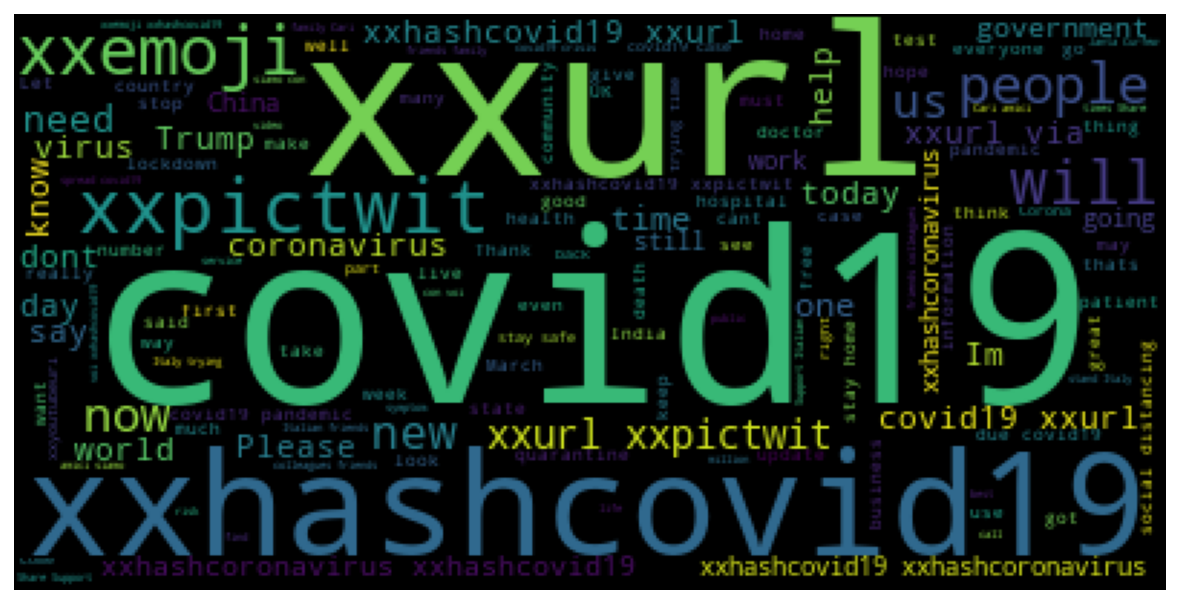

In [38]:
wordcloud_text = ' '.join([t for t in clean_tweets[:10000]])
wordcloud = WordCloud().generate(wordcloud_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0);

In [39]:
wrapper(testtweet, nltk_tokenize=True)

'sarscov2 narendramodi Dear PM Is this really happening The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests xxemoji Unbelievable xxhashcoronavirus xxpictwit xxyoutubeurl xxurl'

In [11]:
clean_tweets = df["tweet"].progress_apply(lambda x: wrapper(x, nltk_tokenize=True))

In [14]:
for n in range(10):
    print(clean_tweets[n])
    print()

I got fired yesterday due to the damage of coronavirus Not only me 70 colleagues got fired from my company People are dying Companies are closing CHINA MUST TAKE RESPONSIBILITY FOR THIS xxhashcovid19 ChinaVirus

covid19 Airlines And OTAs Say Don t Call Us As Travel Agents Come To The Rescue via forbes https xxemoji fr1585094386391dfd

NEW xxhashcoronavirus xxhashcovid19 VETgirl webinar FREE starting in 30 minutes 8 30pm Eastern Sign up now Get the info YOU need to keep yourself your practice your clients and your patients safe Veterinary VetMed VetTech Pandemic xxurl

You may be hearing a lot of concerning information in the news and even in these xxhashcoronavirus prevention tip videos But the best way to proceed is to stay calm stay informed and know the facts Learn more here xxhashcovid19 xxurl

honestly This shit is dark What the Texas lieutenant governor proposed IN REAL LIFE is what I proposed as an absurd way over the top because it's so overtly inhumane remedy meant to call att

In [15]:
wordcloud_text = ' '.join([t for t in clean_tweets[:10000]])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0);

NameError: name 'WordCloud' is not defined

In [74]:
wrapper(testtweet, nltk_tokenize=True)

'sarscov2 narendramodi Dear PM Is this really happening The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests xxemoji Unbelievable xxhashcoronavirus xxpictwit xxyoutubeurl xxurl'

In [28]:
'\'!"'

'\'!"'

In [29]:
string.punctuation + '…–”“’'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~…–”“’'

In [30]:
test123 = "corona virus, \n\ncorona, \n coronavirus, #coronavirus, #corona, #coronavirus5g"
test345 = "covid19,!k \ncovid-19,  \n\n COVID_19, #covid19, #covid-19 #COVID_19, #covid"

In [31]:
coronavirus_hashtags(replace_coronavirus(newline_remove(test123)))

'coronavirus,  corona,   coronavirus, xxhashcoronavirus, #corona, #coronavirus5g'

In [32]:
covid_hashtags(replace_covid(newline_remove(test345)))

'covid19,!k  covid19,    covid19, xxhashcovid19, xxhashcovid19 xxhashcovid19, #covid'

In [33]:
wrapper(test123)

'coronavirus, corona, coronavirus, xxhashcoronavirus, corona, coronavirus5g'

In [34]:
wrapper(test345)

'covid19,!k covid19, covid19, xxhashcovid19, xxhashcovid19 xxhashcovid19, covid'

In [35]:
wrapper(test345, punc_replace=True)

'covid19 k covid19 covid19 xxhashcovid19 xxhashcovid19 xxhashcovid19 covid'

In [24]:
testtweet

'Sars-Cov-2 @narendramodi Dear PM, Is this really happening?\n\nThe countrymen have to pay for COVID-19 \ncorona virus #Covid19 Tests?  🧐 Unbelievable! \n #coronavirus pic.twitter.com/31nvInjcBZ \nhttps://www.youtube.com/watch?v=ig9yh8iVZWI\nhttps://github.com/rkingery/ml_tutorials/blob/master/notebooks/ml_with_text.ipynb\n'

In [36]:
wrapper(testtweet)

'sarscov2 narendramodi Dear PM, Is this really happening? The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests? xxemoji Unbelievable! xxhashcoronavirus xxpictwit xxyoutubeurl xxurl'

In [37]:
wrapper(testtweet, punc_replace=True)

'sarscov2 narendramodi Dear PM Is this really happening The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests xxemoji Unbelievable xxhashcoronavirus xxpictwit xxyoutubeurl xxurl'

In [29]:
wrapper(testtweet, preprocessor=True)

'sarscov2 narendramodi Dear PM, Is this really happening? The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests?  xxemoji  Unbelievable! xxhashcoronavirus $URL$ $URL$ $URL$'

In [32]:
wrapper(testtweet, punc_space=True, preprocessor=True)

'sarscov2 narendramodi Dear PM xxpunct Is this really happening xxpunct The countrymen have to pay for covid19 coronavirus xxhashcovid19 Tests xxpunct xxemoji Unbelievable xxpunct xxhashcoronavirus xxpunct URL xxpunct xxpunct URL xxpunct xxpunct URL xxpunct'

### _Gather sample set of 1,000 Tweets_

In [16]:
subset = df.sample(n=1000, random_state=1)

In [66]:
clean_tweets = subset["tweet"].apply(lambda x: wrapper(x, nltk_tokenize=True))

In [67]:
for n in range(10):
    print(clean_tweets[n])
    print()

coronavirus covid19 Business Advice xxurl

Find the latest xxhashcovid19 information and resources on CTA's covid19 Information Page xxurl xxpictwit

coronavirus disease covid19 Update at 7 10 GMT xxemoji xxemoji Total Confirmed cases 382 031 xxemoji Total Confirmed deaths 16 565 xxemoji Total Number of Recovered patients 102 481 xxhashcovid19 CovidCount Corona xxhashcoronavirus Wuhan coronapocalypse

Isolation is so important to prevent xxhashcoronavirus outbreak COVID xxhashcovid19 italia italy CoronaInfoCH xxhashcoronavirus coronavirusOutbreak coronaviruschina coronavirusItaly coronavirusIran coronavirusPandemic italia italy italie italien xxhashcovid19 COVID2019

A hint of good news for Italy xxemoji Lombardy Italy reports first day of decreasing hospitalizations in region due to covid19 coronavirus xxurl

Where's the first place you're going after this is all over xxhashcovid19 xxhashcoronavirus coronapocalypse vacation xxpictwit

We stand by Italy during these trying times Share 

### _WordCloud of Sample_

In [68]:
from wordcloud import WordCloud

In [69]:
def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)

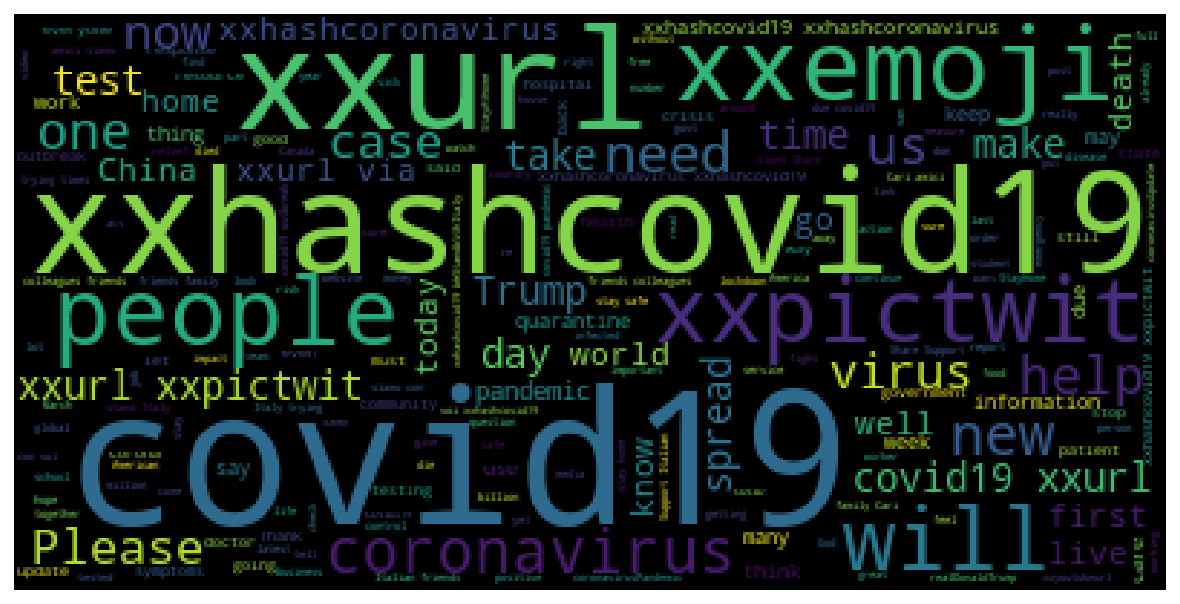

In [70]:
show_wordcloud(clean_tweets)

In [44]:
from nltk.tokenize import RegexpTokenizer

In [90]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
tweet2 = '''
I’ll “stay away from anyone you love or respect”. 

Will you stay away from the 5G towers that emulate Covid19 symptoms? 

Will you research the 5G rollout in Wuhan late last year? 

Will you learn that 5G causes respiratory failure by inhibiting hemoglobin-oxygen transfer?

#5G
'''

In [41]:
re.sub(r"\b\w*[-']\w*\b", '', tweet2, re.I)

'\nI’ll “stay away from anyone you love or respect”. \n\nWill you stay away from the 5G towers that emulate Covid19 symptoms? \n\nWill you research the 5G rollout in Wuhan late last year? \n\nWill you learn that 5G causes respiratory failure by inhibiting  transfer?\n\n#5G\n'

In [71]:
wrapper(tweet2, nltk_tokenize=True)

'I ll stay away from anyone you love or respect Will you stay away from the 5G towers that emulate covid19 symptoms Will you research the 5G rollout in Wuhan late last year Will you learn that 5G causes respiratory failure by inhibiting hemoglobin oxygen transfer 5G'

In [402]:
def sarscov2_replace(text):
    regex = re.compile(r'(sars[-]?cov[-]?2)', re.I)
    return regex.sub(r'sarscov2', text)

sarscov2_replace('SARS-CoV-2')

'sarscov2'

In [127]:
test123 = '#corona, #Coronavirus, #CoronavirusTrump, #CoronaTrump, corona virus, coronavirus'

In [128]:
punctuation_space(test123)

' # corona , # Coronavirus , # CoronavirusTrump , # CoronaTrump , corona virus , coronavirus'

In [120]:
coronavirus_hashtags(test123)

'coronavirus coronavirus coronavirus coronavirus corona virus, coronavirus'

In [114]:
test123 = '#COVID_19, #covid-19, #covid19, #covid_19, COVID19'

In [115]:
covid_hashtags(test123)

'covid19, covid19, covid19, covid19, COVID19'

In [129]:
wrapper(test123)

'coronavirus coronavirus coronavirus coronavirus coronavirus , coronavirus'

In [134]:
wrapper(testtweet)

'$MENTION$ Dear PM, Is this really happening? The countrymen have to pay for covid19 Tests? 🧐 Unbelievable! $URL$'

In [135]:
p.tokenize(wrapper(testtweet))

'$MENTION$ Dear PM, Is this really happening? The countrymen have to pay for covid19 Tests? 🧐 Unbelievable! $URL$'

In [137]:
p.tokenize('RT Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

'$RESERVED$ Preprocessor is $HASHTAG$ $EMOJI$ $URL$'

# New update to make sure git is set up correctly

**To be continued...**

## _Experimenting w/ [`tweet-preprocessor 0.5.0`](https://pypi.org/project/tweet-preprocessor/)_